In [1]:
import openchord as ocd
import pandas as pd
import networkx as nx
import os
# go one up
os.chdir("..")

In [2]:
vos_links = pd.read_csv(f'data{os.sep}prepared{os.sep}vos_links.csv')
vos_links.head()

,VOS_Source_ID,VOS_Target_ID,Strength
0,2,3,2.0
1,2,5,5.0
2,2,6,5.0
3,2,7,1.0
4,2,8,4.0


In [3]:
vos_meta = pd.read_csv(f'data{os.sep}prepared{os.sep}vos_meta.csv')
vos_meta.head()

,VOS_ID,Authors,Title,Year,Citations,Source,Cluster,Links,Total link strength,Norm. citations
0,2,['Nick Bostrom'],Existential Risk Prevention As Global Priority,2013,310.0,Global policy,4,217.0,394.0,10.1703
1,3,"['Shahar Avin', ' Bonnie Wintle', ' Julius Wei...",Classifying Global Catastrophic Risks,2018,65.0,Futures,4,162.0,226.0,4.9029
2,5,['Nick Bostrom'],Existential Risks: Analyzing Human Extinction ...,2002,73.0,[no source],4,38.0,56.0,1.9797
3,6,"['Seth D. Baum', ' Itsuki C. Handoh']",Integrating The Planetary Boundaries And Globa...,2014,45.0,Ecological economics,4,259.0,552.0,2.4338
4,7,"['Simon Beard', ' Lauren Holt', ' Asaf Tzachor...",Assessing Climate Change’S Contribution To Glo...,2021,32.0,Futures,1,203.0,416.0,5.3161


In [4]:
# Merge via the 'VOS_ID' column
vos_source = pd.merge(vos_links, vos_meta, right_on='VOS_ID', left_on='VOS_Source_ID')
vos_source = vos_source[['VOS_Source_ID', 'VOS_Target_ID', "Strength", "Cluster"]]
vos_source.columns = ['Source', 'Target', 'Strength', 'Source Cluster']
vos_source.head()

,Source,Target,Strength,Source Cluster
0,2,3,2.0,4
1,2,5,5.0,4
2,2,6,5.0,4
3,2,7,1.0,4
4,2,8,4.0,4


In [5]:
# Merge again to get the target cluster
vos_target = pd.merge(vos_links, vos_meta, right_on='VOS_ID', left_on='VOS_Target_ID')
vos_target = vos_target[['VOS_Source_ID', 'VOS_Target_ID', "Strength", "Cluster"]]
vos_target.columns = ['Source', 'Target', 'Strength', 'Target Cluster']
vos_target.head()


,Source,Target,Strength,Target Cluster
0,2,3,2.0,4
1,2,5,5.0,4
2,2,6,5.0,4
3,2,7,1.0,1
4,2,8,4.0,4


In [6]:
assert vos_target.shape[0] == vos_source.shape[0]
# Merge the two dataframes
vos = pd.merge(vos_source, vos_target, on=['Source', 'Target', 'Strength'])
vos.head()

,Source,Target,Strength,Source Cluster,Target Cluster
0,2,3,2.0,4,4
1,2,5,5.0,4,4
2,2,6,5.0,4,4
3,2,7,1.0,4,1
4,2,8,4.0,4,4


In [7]:
# Analyse how much strength is from one cluster to another
cluster_strength = vos[["Strength", "Source Cluster", "Target Cluster"]].groupby(['Source Cluster', 'Target Cluster']).sum()
cluster_strength

Strength
Source Cluster Target Cluster          
1              1                 1957.0
               2                  420.0
               3                  447.0
               4                  936.0
               5                  428.0
...                                 ...
8              4                 1620.0
               5                  418.0
               6                  123.0
               7                  265.0
               8                 1542.0

[64 rows x 1 columns]

In [8]:
# Create a graph from the cluster strength
G = nx.DiGraph()
for index, row in cluster_strength.iterrows():
    # Skip self loops
    if index[0] == index[1]:
        continue
    G.add_edge(index[0], index[1], weight=row['Strength'])

In [9]:
# Get an adjacency matrix
adjacency_matrix = nx.to_pandas_adjacency(G)
adjacency_matrix

,1,2,3,4,5,6,7,8
1,0.0,420.0,447.0,936.0,428.0,205.0,189.0,582.0
2,224.0,0.0,166.0,819.0,396.0,103.0,294.0,424.0
3,329.0,106.0,0.0,199.0,251.0,86.0,97.0,139.0
4,1214.0,1687.0,563.0,0.0,970.0,267.0,569.0,2013.0
5,413.0,457.0,234.0,535.0,0.0,49.0,151.0,204.0
6,202.0,146.0,147.0,243.0,95.0,0.0,70.0,154.0
7,91.0,231.0,76.0,297.0,148.0,47.0,0.0,149.0
8,552.0,730.0,322.0,1620.0,418.0,123.0,265.0,0.0


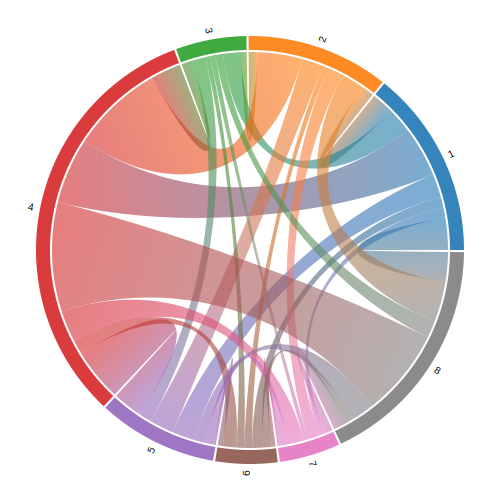

In [10]:
fig = ocd.Chord(adjacency_matrix, [str(i) for i in adjacency_matrix.columns])
# Get the colors from tab10
fig.colormap = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
fig.show()